
### Calibração do Motor

Os dados considerados neste exercício são:

| Componente    | Eficiência Adiabática| $\gamma$            |
|---------------|----------------------|-------------------  |
| entrada do ar | 0,85                 | 1,40                |
| compressor    | 0,75                 | 1,37                |
| combustão     | 1,00                 | 1,35                |
| turbina       | 0.90                 | 1,33                |
| bocal         | 0,98                 | 1,36                |
| turbina livre | 0,90                 | 1,33                |


E os dados operacionais são:

| Dados operacionais:                           | Valor             |
|-----------------------------------------------|-------------------|
| Razão de Pressão no compressor                | 12                |
| Temperatura na sáida da câmara de combustão   | 1400 K            |
| Poder Calorífico Inferior do Combustível      | 45000 kJ/kg       |
| R Médio                                       | 288,3 m^2/(s^2.K) |
| Cp no combustor                               | 1,11 kJ/(kg.K)    |
| Cp na turbina livre                           | 1,11 kJ/(kg.K)    |
| Cp na turbina livre isentrópica               | 1,16 kJ/(kg.K)    |
| Razão de potência na caixa de redução         | 0,98              |
| Efiiciência da Hélice                         | 0,85              |

Inicialmente, o motor foi calibrado considerando os seguintes parâmetros:

| Dados operacionais:     | Valor     |
|-------------------------|-----------|
| Mach                    | 0 M       |
| Rotação N2              | 1         |
| Vazão de ar             | 6,7 kg/s  |
| Temperatura ambiente    | 288,2 K   |
| Pressão ambiente        | 101,3 kPa |

Para isso, como o único parâmetro que não foi informado foi a razão de expansão na turbina livre (pr_tl), este parâmetro foi determinado variando-o até que a potência obtida fosse a máxima fornecida pelo motor, ou seja, a maior potência termodinâmica que é igual à 1440 kW. Essa potência do motor corresponde às condições acima e não considera a potência limite da caixa de redução. No código, apenas a variável pr_tl que corresponde a essa razaão de expansão foi variada de 0.0001 em 0.0001, desde o valor igual a 2 e até que a potência obtida fosse igual à 1440kW. A cada variação a potência obtida foi comparada com o valor de 1440 kW, logo foi obtida a razão de expansão na turbina livre que permite ao motor fornecer a potência de 1440kW dada as condições acima.

Razão de expansão na turbina livre:  2.406000000000857


,1
BSFC,0.000088
EBSFC,0.000088
TSFC,0.058889
aircraft_speed,0.000000
fuel_consumption,0.127352
gearbox_power,1411.169111
mass_flow,6.697185
specific_power_turbine,215.011012
specific_thrust,0.322911
thrust_hot_air,2.162595


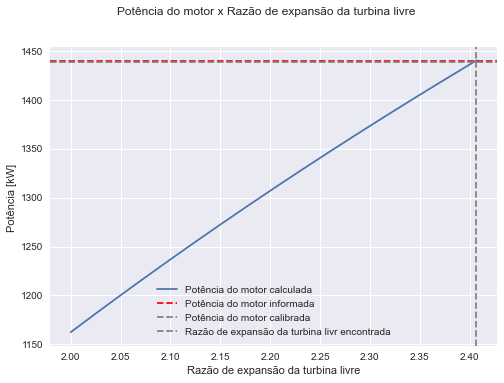

In [1]:
import model_reference as mf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')

values = {
    'mass_flow': 6.7,  # Vazão mássica = vazão de ar no compressor [kg/s]
    't04': 1400,       # Temperatura da saída da câmara de combustão [K]
    'prc': 12,         # Razão de pressão do compressor
    'mach': 0,         # Mach de voo [M]
    'ta': 288.2,       # Temperatura ambiente [K]
    'pa': 101.3,       # Pressão ambiente [kPa]
    'n_d': 0.85,       # Eficiência da entrada de ar
    'gamma_d': 1.4,    # Gamma da entrada de ar
    'n_c': 0.75,       # Eficiência do compressor
    'gamma_c': 1.37,   # Gamma do compressor
    'n_b': 1,          # Eficiência da câmera de combustão
    'gamma_b': 1.35,   # Gamma da câmera de combustão
    'n_t': 0.9,        # Eficiência da turbina do compressor
    'gamma_t': 1.33,   # Gamma da turbina do compressor
    'n_tl': 0.9,       # Eficiência da turbina livre
    'gamma_tl': 1.33,  # Gamma da turbina livre
    'n_n': 0.98,       # Eficiência do bocal de gases quentes
    'gamma_n': 1.36,   # Gamma do bocal de gases quentes
    'pc_fuel': 45000,  # Poder calorífico inferior do combustível [kJ/kg]
    'cp_fuel': 1.110,  # Cp no combustor [kJ/(kg.K)]
    'cp_tls': 1.160,
    'cp_tl': 1.110,
    'r': 288.3,        # R médio m2/(s2.K)
    'pr_tl': 2.87,                # Razão de pressão da turbina livre    
    'gearbox_power_ratio': 0.98,     # Razão de potência da gearbox
    'propeller_efficiency': 0.85, # Eficiência da hélice
    }

# Para calibrar o motor inicialmente para permitir que a potência do motor produzida seja 1440 kW
turbine_power_target = 1440 #[kW]

turbine_pressure_ratio = 2.0
values["pr_tl"] = turbine_pressure_ratio
turbine_pressure_ratio_delta = 0.0001

turboprop = mf.TurboProp(values)
turboprop.set_n2(1)

performance_results = turboprop.sumarise_results()

while(int(performance_results.loc['turbine_power']) < turbine_power_target):
    turbine_pressure_ratio = turbine_pressure_ratio + turbine_pressure_ratio_delta
    values["pr_tl"] = turbine_pressure_ratio
    turboprop = mf.TurboProp(values)
    performance_results = turboprop.sumarise_results()

turbine_pressure_ratio = turbine_pressure_ratio - turbine_pressure_ratio_delta
values["pr_tl"] = turbine_pressure_ratio
turboprop = mf.TurboProp(values)
performance_results = turboprop.sumarise_results()
resp_performance_results = performance_results

# Build Graph
list_of_prtl = np.arange(2.0, turbine_pressure_ratio+10*turbine_pressure_ratio_delta, turbine_pressure_ratio_delta)
turboprop = mf.TurboProp(values)
performance_results = turboprop.sumarise_results()
turbine_power = int(performance_results.loc['turbine_power'])
performance_results = performance_results.drop(columns=[1])

for prtl in list_of_prtl:
    values["pr_tl"] = prtl
    turboprop = mf.TurboProp(values)
    performance_result = turboprop.sumarise_results()
    performance_results[prtl] = performance_result

fig4a1 = plt.figure()
fig4a1.suptitle("Potência do motor x Razão de expansão da turbina livre")
axis1 = fig4a1.add_subplot(111)
axis1.plot(performance_results.keys(), performance_results.loc['turbine_power'], label = 'Potência do motor calculada')
axis1.set_ylabel("Potência [kW] ")
axis1.set_xlabel("Razão de expansão da turbina livre")
axis1.axhline(turbine_power_target, linestyle='--', color='red', label='Potência do motor informada')
axis1.axhline(turbine_power, linestyle='--', color='gray', label='Potência do motor calibrada')
axis1.axvline(turbine_pressure_ratio, linestyle='--', color='gray', label='Razão de expansão da turbina livr encontrada')
axis1.legend()

# save the plot as a file
fig4a1.savefig('images/questao4/calib_pt_tl.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

print("Razão de expansão na turbina livre: ", turbine_pressure_ratio)
resp_performance_results

Como o motor tinha sido calibrado em uma rotação de 100% e com essa rotação o motor fornece a potência máxima, a rotação do motor foi diminuida até que a potência entregue pelo motor fosse menor ou igual à potência da caixa de redução, que é 1282 K. Assim, no código e utilizando como razão de expansão da turbina livre o valor encontrado anteriormente, a variável N2, que representa a rotação entre 0 e 1, foi variada de 0.0001 em 0.0001. A cada variação a potência do motor foi comparada à potência limite da caixa de redução. E enquanto a potência do motor fosse maior do que a potência limite, a rotação N2 foi diminuída até que a potência do motor fosse menor ou igual à potência limite, obtendo assim o valor de rotação N2 com o qual o motor entrega a potência limite da caixa de redução.

Rotação:  0.9572000000000047


,0.9572
BSFC,0.000086
EBSFC,0.000086
TSFC,0.071521
aircraft_speed,0.000000
fuel_consumption,0.110305
gearbox_power,1256.933606
mass_flow,6.201927
specific_power_turbine,206.804317
specific_thrust,0.248676
thrust_hot_air,1.542273


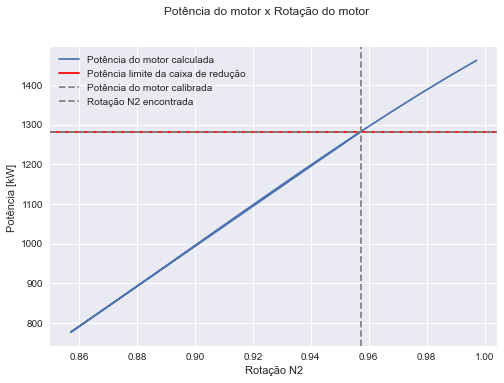

In [2]:
# Calibrar o motor para potência 1282kW
N2 = 1
N2_delta = 0.0001
turbine_power_target = 1282 #[kw]

# Get right simulation
values["pr_tl"] = turbine_pressure_ratio
turboprop.set_n2(N2)
turboprop = mf.TurboProp(values)
performance_results = turboprop.sumarise_results()

while(int(performance_results.loc['turbine_power']) > turbine_power_target):
    N2 = N2 - N2_delta
    turboprop.set_n2(N2)
    performance_results = turboprop.sumarise_results()

turbine_power = int(performance_results.loc['turbine_power'])

list_of_n2 = np.arange(N2-10*0.01, 1, 0.01)

for n2 in list_of_n2:
    turboprop.set_n2(n2)
    performance_result = turboprop.sumarise_results()
    performance_results[n2] = performance_result

fig4a2 = plt.figure()
fig4a2.suptitle("Potência do motor x Rotação do motor")
axis1 = fig4a2.add_subplot(111)
axis1.plot(performance_results.keys(), performance_results.loc['turbine_power'], label = 'Potência do motor calculada')
axis1.set_ylabel("Potência [kW] ")
axis1.set_xlabel("Rotação N2")
axis1.axhline(turbine_power_target, linestyle='-', color='red', label='Potência limite da caixa de redução')
axis1.axhline(turbine_power, linestyle='--', color='gray', label='Potência do motor calibrada')
axis1.axvline(N2, linestyle='--', color='gray', label='Rotação N2 encontrada')
axis1.legend()

# save the plot as a file
fig4a2.savefig('images/questao4/calib_N2.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

print("Rotação: ", N2)
turboprop.set_n2(N2)
performance_result = turboprop.sumarise_results()
performance_result

